# Gym solving - PPO
---
- PPO(Proximal Policy Optimization)

In [1]:
# 해당 셀은 필자의 Jupyter notebook 환경 문제로 인해 작성되었습니다
import os
try:
    os.environ["DISPLAY"]
except:
    os.environ["SDL_VIDEODRIVER"] = "dummy"
os.environ["SDL_VIDEODRIVER"] = "dummy"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import gym
import copy
import sys
sys.path.append('../material')
from utils import moving_average, discounted_reward, FIFO

from IPython.display import clear_output
from IPython.display import Video

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
torch.manual_seed(123)
torch.cuda.manual_seed_all(123)
np.random.seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
env = gym.make('CartPole-v0')
env.seed(123)
env._max_episode_steps=500

/home/hyunseok.hwang/anaconda3/envs/RL_scratch/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


# PPO agent생성

In [84]:
class PPO_agent(nn.Module):
    def __init__(self, state_shape, n_actions):
        super(PPO_agent,self).__init__()
        '''
        입력변수
            state_shape: state 차원 -> [위치, 속도, 각도, 각속도]
            output_dim: actor 차원 -> [왼쪽, 오른쪽]
                        critic 차원 -> 1
            device : cpu, cuda device정보 
        N.N 구조
            2 - hidden layers, 64 nodes
            Activation function -> Relu
        '''
        self.state_shape = state_shape
        self.n_actions = n_actions
        
        self.seq = nn.Sequential(
            nn.Linear(self.state_shape,64), 
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
        )
        self.actor = nn.Linear(64,n_actions)
        self.critic = nn.Linear(64,1)

    def forward(self, state_t):
        policy = self.actor(self.seq(state_t))
        value = self.critic(self.seq(state_t))
        return policy, value

    def sample_actions(self,state_t):
        policy,_ = self.forward(state_t)
        policy = torch.squeeze(policy)
        softmax_policy = F.softmax(policy,dim=-1)
        action = torch.distributions.Categorical(softmax_policy).sample().item()
        return action

In [126]:
gamma=0.99
scheduler_gamma=0.999
scheduler_step=10
epsilon = 1e-02
eps = 0.2
value_ratio=0.5

state = env.reset()
num_state = state.shape[0]
num_action = env.action_space.n
learning_rate = 1e-03
max_episode = 1000
update_per_episode=5

# Clipped Surrogate Objective
---
Objective function

$$

J(\theta) = \mathbb{E}_t[min(r_t(\theta)\hat{A}_t,clip(r_t(\theta),1-\epsilon,1+\epsilon)\hat{A}_t)]

$$

where,
$r_t(\theta) = \frac{\pi{(a_t \vert s_t)}}{\pi_{old}(a_t \vert s_t)}$

In [130]:
agent = PPO_agent(num_state,num_action).to(device)
optimizer = optim.Adam(agent.parameters(),lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=scheduler_step,gamma=scheduler_gamma)

In [131]:
def PPO_update(histories, num_update=3, agent=agent, optimizer=optimizer,scheduler=scheduler):
    states, actions, policies, rewards, next_states, dones = histories
    old_proba = torch.Tensor(policies).to(device).detach()
    torch_state = torch.Tensor(states).to(device)
    torch_next_state = torch.Tensor(next_states).to(device)
    for _ in range(num_update):
        policy, value = agent(torch_state)
        _, next_value = agent(torch_next_state)
        soft_policy = F.softmax(policy,dim=-1)
        #print(soft_policy.device, torch.Tensor(actions).unsqueeze(1).shape)
        cur_proba = torch.gather(soft_policy,1,torch.tensor(actions).unsqueeze(1).to(device))
        #old_proba = torch.Tensor(policies).to(device)
        ratio = torch.exp(torch.log(cur_proba)-torch.log(old_proba))
        
        td_target = torch.Tensor(rewards).to(device) + gamma * next_value * torch.Tensor(dones).to(device)
        td_delta = td_target - value
        td_delta = td_delta.detach().cpu().numpy()
        advantage = torch.Tensor(discounted_reward(td_delta)).to(device)

        surr_1 = ratio*advantage
        surr_2 = torch.clip(ratio, 1-eps, 1+eps)*advantage
        clip_loss = torch.min(surr_1, surr_2)
        critic_loss = (td_target - value)**2
        entropy = -torch.sum(soft_policy*torch.log(soft_policy),dim=-1)
    
        # loss function build
        loss = torch.mean(-clip_loss + value_ratio*critic_loss - epsilon*entropy)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    return loss.item(), -clip_loss.mean().item(), critic_loss.mean().item(), entropy.mean().item()

990번째 에피소드 결과
최근 10 에피소드 보상평균 = 27.1


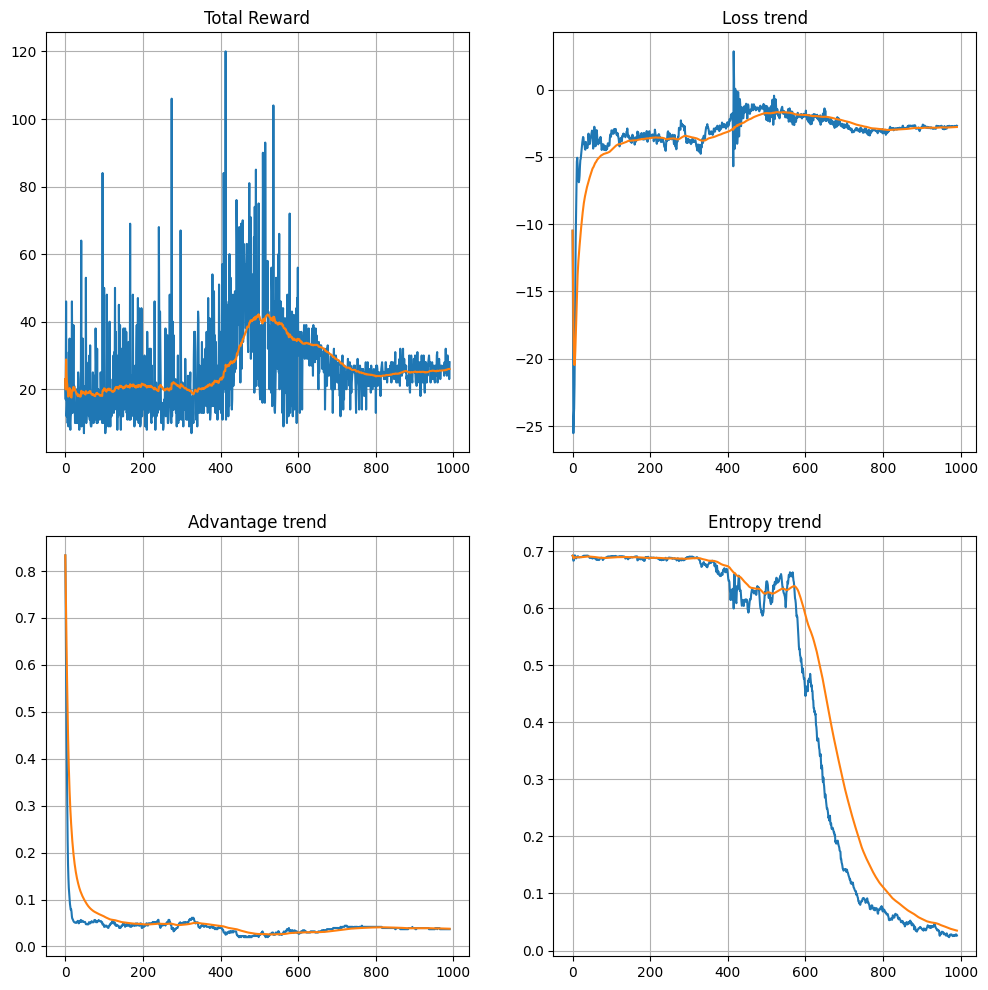

In [132]:
reward_record, loss_record, critic_record, entropy_record = [], [], [], []
states, actions, policies, rewards, next_states, dones = [],[],[],[],[], []
for ep in range(max_episode):
    total_reward = 0
    state = env.reset()
    
    while True:
        torch_state = torch.Tensor(state[None]).to(device)
        policy, value = agent(torch_state)
        soft_policy = F.softmax(policy,dim=-1).squeeze()
        action =  agent.sample_actions(torch_state)
        prob_a = soft_policy[action]
        next_state, reward, done, _ = env.step(action)
        
        states = FIFO(state, states)
        actions = FIFO(action, actions)
        policies = FIFO(prob_a, policies)
        rewards = FIFO(reward, rewards)
        next_states = FIFO(next_state, next_states)
        dones = FIFO(done, dones)

        if done:
            break

        state = next_state
        total_reward += reward
    history = (states, actions, policies, rewards, next_states, dones)
    # Episode finish -> update agent model
    loss,clip,critic,entropy = PPO_update(history, update_per_episode)
    reward_record.append(total_reward)
    loss_record.append(loss) 
    critic_record.append(critic)
    entropy_record.append(entropy)

    if ep % 10 == 0:
        clear_output(True)
        print(f'{ep}번째 에피소드 결과')
        print(f'최근 10 에피소드 보상평균 = {np.mean(reward_record[-10:])}')

        plt.figure(figsize=[12, 12])
        
        plt.subplot(2,2,1)
        plt.title("Total Reward")
        plt.plot(reward_record)
        plt.plot(moving_average(reward_record))
        plt.grid()

        plt.subplot(2,2,2)
        plt.title("Loss trend")
        plt.plot(loss_record)
        plt.plot(moving_average(loss_record))
        plt.grid()

        plt.subplot(2,2,3)
        plt.title("Advantage trend")
        plt.plot(critic_record)
        plt.plot(moving_average(critic_record))
        plt.grid()
        
        plt.subplot(2,2,4)
        plt.title("Entropy trend")
        plt.plot(entropy_record)
        plt.plot(moving_average(entropy_record))
        plt.grid()

        plt.show()
    
    if np.mean(reward_record[-10:]) >= 400:
        best_agent = copy.deepcopy(agent)
        torch.save(best_agent,'./ckpt/CartPole/PPO_bestagent.pth')

# Play the video

In [26]:
agent = torch.load('./ckpt/CartPole/PPO_bestagent.pth')

In [27]:
import gym.wrappers

def record(initial_state,agent,env,vid):
    state = initial_state
    sum_rewards = 0

    while True:
        vid.capture_frame()
        torch_state = torch.Tensor(state[None]).to(device)
        policy, value = agent(torch_state)
        soft_policy = F.softmax(policy,dim=-1).squeeze()
        action =  agent.sample_actions(torch_state)

        next_state,reward,done,_ = env.step(action)
        
        state = next_state
        sum_rewards += reward
        if done:
            break
    vid.close()
    return sum_rewards

env = gym.make('CartPole-v0')
env._max_episode_steps=600
env.seed(123)
vid = gym.wrappers.monitoring.video_recorder.VideoRecorder(env,path='./videos/CartPole/PPO_CartPole_video.mp4')
vid.render_mode="rgb_array"

state = env.reset()
rewards = record(state,agent,env,vid)
print(rewards)

/home/hyunseok.hwang/anaconda3/envs/RL_scratch/lib/python3.8/site-packages/gym/envs/registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(


error: No available video device

In [ ]:
Video('./videos/CartPole/PPO_CartPole_video.mp4',embed=True,width=512, height=512)